# Snow Cover Extent

Observation: [NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
](https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756)

## Import des modules

In [33]:
import intake 
import xarray as xr
import proplot as plot
import xesmf as xe
import numpy as np

## Get observation

In [8]:
ds_obs = xr.open_dataset('data/NOAA_CDR_NH_SCE/nhsce_v01r01_19661004_20201005.nc')

In [9]:
# ds_obs

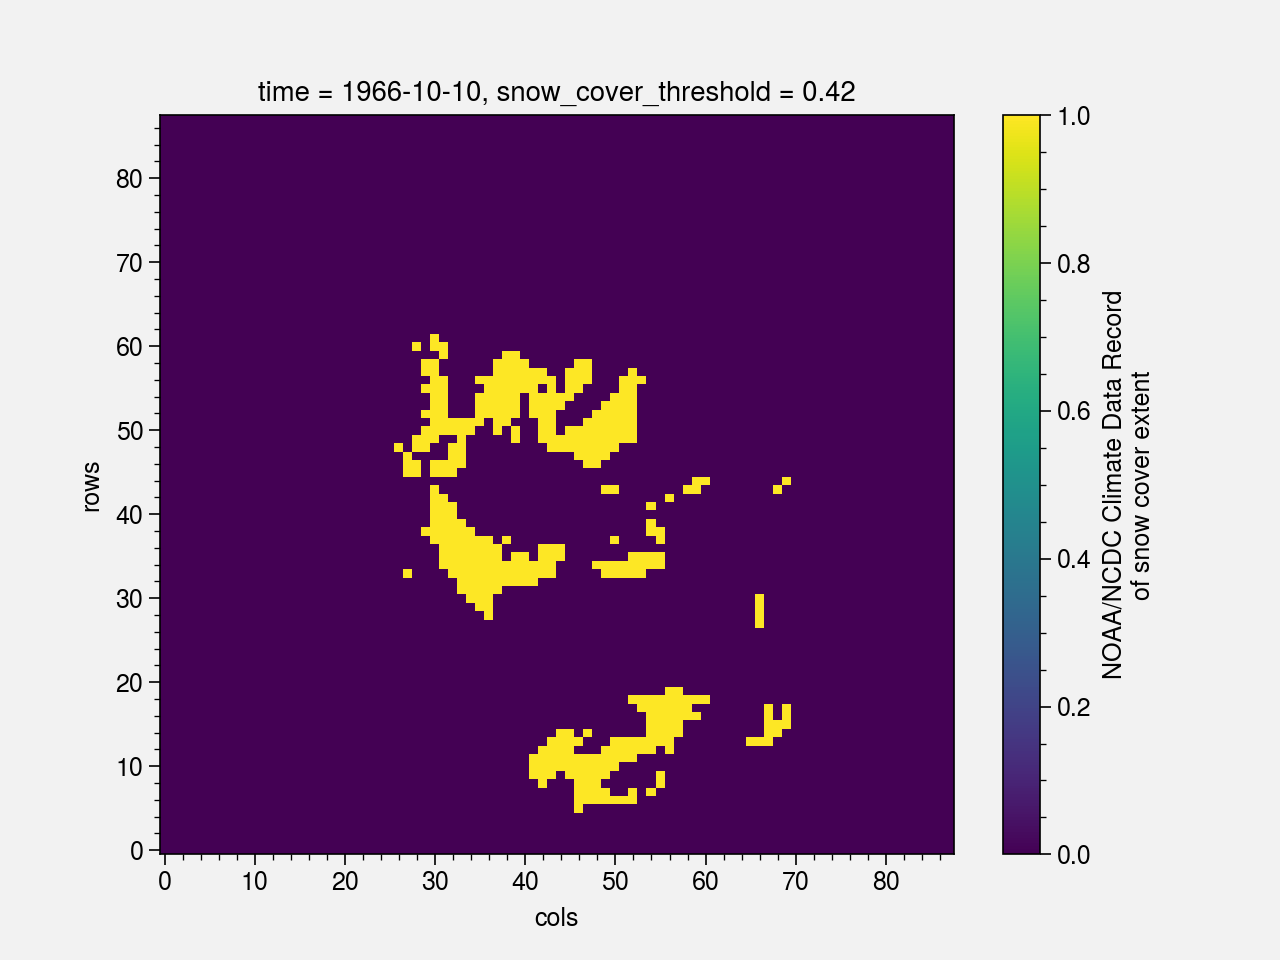

In [10]:
ds_obs.snow_cover_extent.isel(time=0).plot()

In [13]:
obs_name = 'NH_SCE_CDR'

# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_obs.snow_cover_extent.where(
        ds_obs.land == 1) * 100
obs.attrs['units'] = '%'
obs.attrs['obs_name'] = obs_name
obs.attrs.update(ds_obs.attrs)

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
obs = obs \
    .resample(time='1MS') \
    .mean('time', skipna='False', keep_attrs=True)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


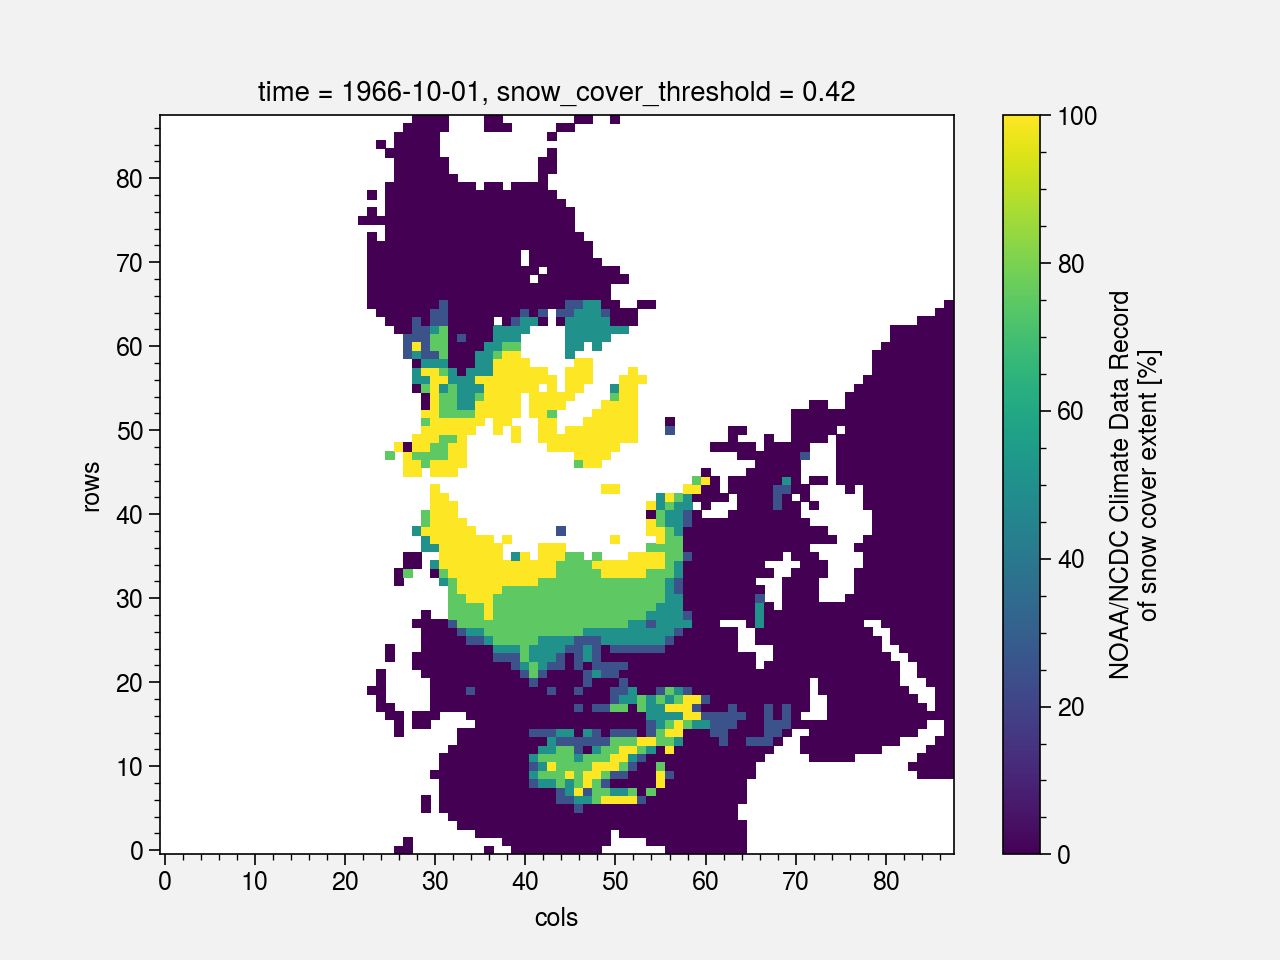

In [15]:
obs[0].plot()

## Récupération des données CMIP6 via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
Cela est possible grâce au projet [Pangeo](https://pangeo.io/) et aux [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) ! (encore assez expérimental)

Autrement il faut télécharger les données sur https://esgf-node.llnl.gov/search/cmip6/ (base de données officielle à l'échelle internationale, mais cela est beaucoup plus fastidieux)

In [16]:
# Visualise toutes les données disponibles (on ne télécharge rien ici pour le moment)

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
# col

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Selection des données souhaitées
Ici je mets donc le modèle `IPSL-CM6A-LR` pour la variable `tas` (température de l'air proche de la surface - de manière générale à 2 mètres au-dessus du sol), en mensuel (soit la table Atmosphérique monthly `Amon`). Pour commencer vous pouvez regarder le premier membre `r1i1p1f1` puis ensuite essayer d'estimer la variabilité interne du modèle et estimer une erreur sur vos résultats de projection.

In [60]:
cat = col.search(
    experiment_id=["historical"],
#     experiment_id=["historical", "ssp585"],
    table_id="LImon",
    variable_id="snc",
    source_id="IPSL-CM6A-LR",
    member_id="r1i1p1f1"
)

cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


In [61]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,LImon,snc,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803


In [62]:
cat.keys()

['CMIP.IPSL.IPSL-CM6A-LR.historical.LImon.gr']

In [20]:
# Optionnel pour la parallélisation

# from dask.distributed import Client
# # client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
# client = Client()
# client

In [63]:
# Cette cellule permet de récupérer les données sous forme de dataset xarray/dask mais rien n'est encore loadé sur votre PC
# Cela peut prendre quelques minutes le temps d'indexer toutes les données

data_source = cat[cat.keys()[0]]
ds = data_source(
    zarr_kwargs={"consolidated": True, "decode_times": True}
).to_dask()

In [23]:
# ds

In [12]:
# client.close()

### Vérification de la taille des données

In [24]:
# Vérifier la taille des données (voir fonction ci-dessous pour avoir quelque chose de lisible)
ds.nbytes

163137348

In [25]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [26]:
convert_size(ds.nbytes)

'155.58 MB'

In [21]:
# Juste pour exemple, à ne pas faire, si pas en parallèle car peut être très long

# ds.tas.mean('time').compute()

En fonction de la taille il peut être judicieux de sélectionner les données que vous avez besoin avant de faire des opérations afin de ne surcharger la mémoire de votre PC ! (surtout avec tous les membres)

## Regrid des obs sur la grille modèle

In [31]:
import scipy

def add_matrix_NaNs(regridder):
    """
        Add NaN values outside of the grid (otherwise 0 values are put by
        default in xESMF)
        See more: https://github.com/JiaweiZhuang/xESMF/issues/15
    """
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)

    return regridder

In [34]:
# Make the regridder
regridder = xe.Regridder(obs, ds, 'bilinear', periodic=False, reuse_weights=True)

# Add NaN instead of 0 for non domain points
regridder = add_matrix_NaNs(regridder)

# Make the regrid
obs_regrid = regridder(obs)

Reuse existing file: bilinear_88x88_143x144.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


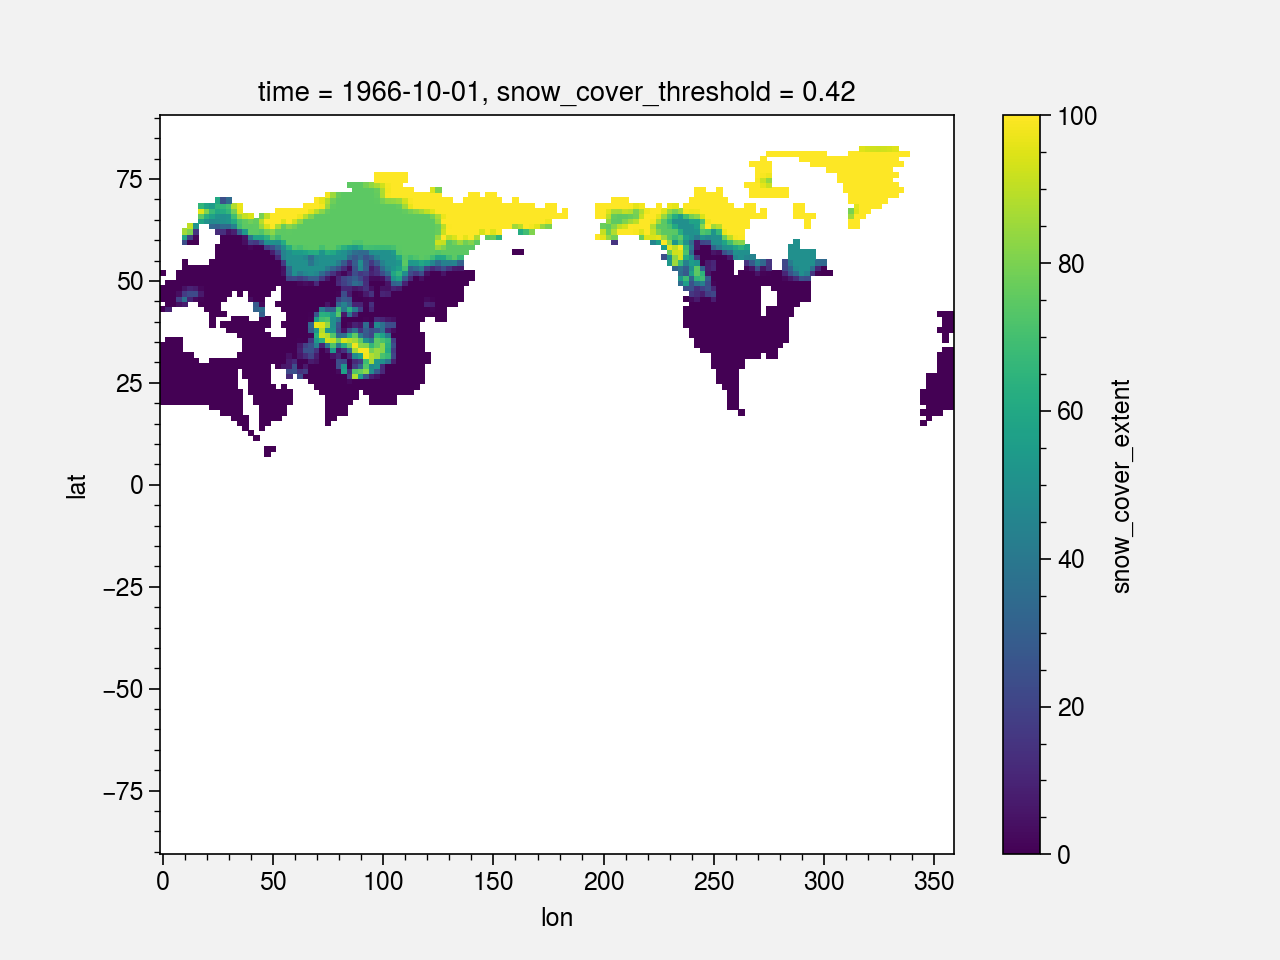

In [64]:
obs_regrid[0].plot()

In [66]:
obs_clim = obs_regrid.sel(time=slice('1979','2014')).mean('time')
model_clim = ds.snc.sel(time=slice('1979','2014')).mean('time').isel(member_id=0)

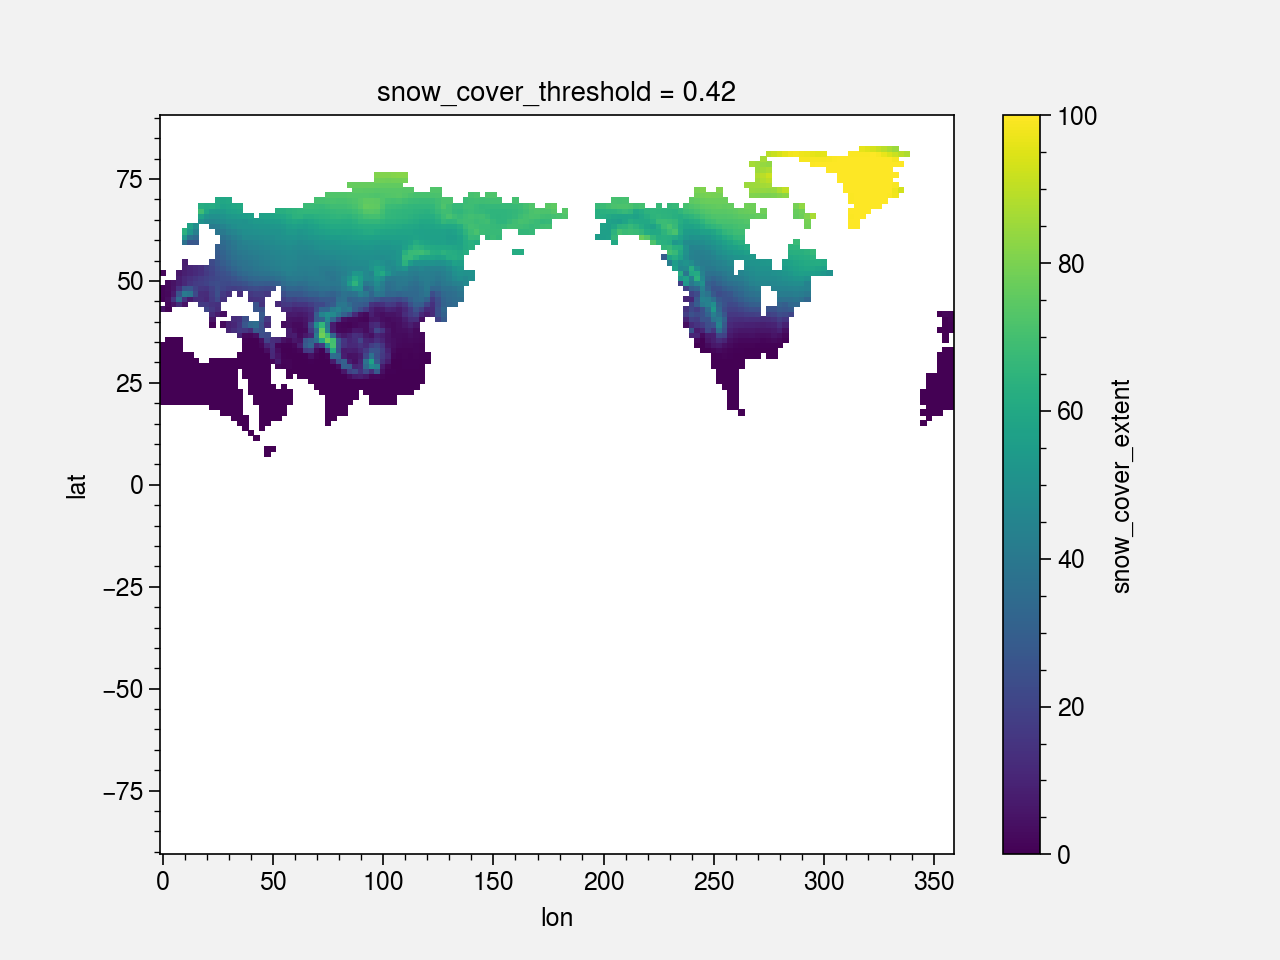

In [68]:
obs_clim.plot()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


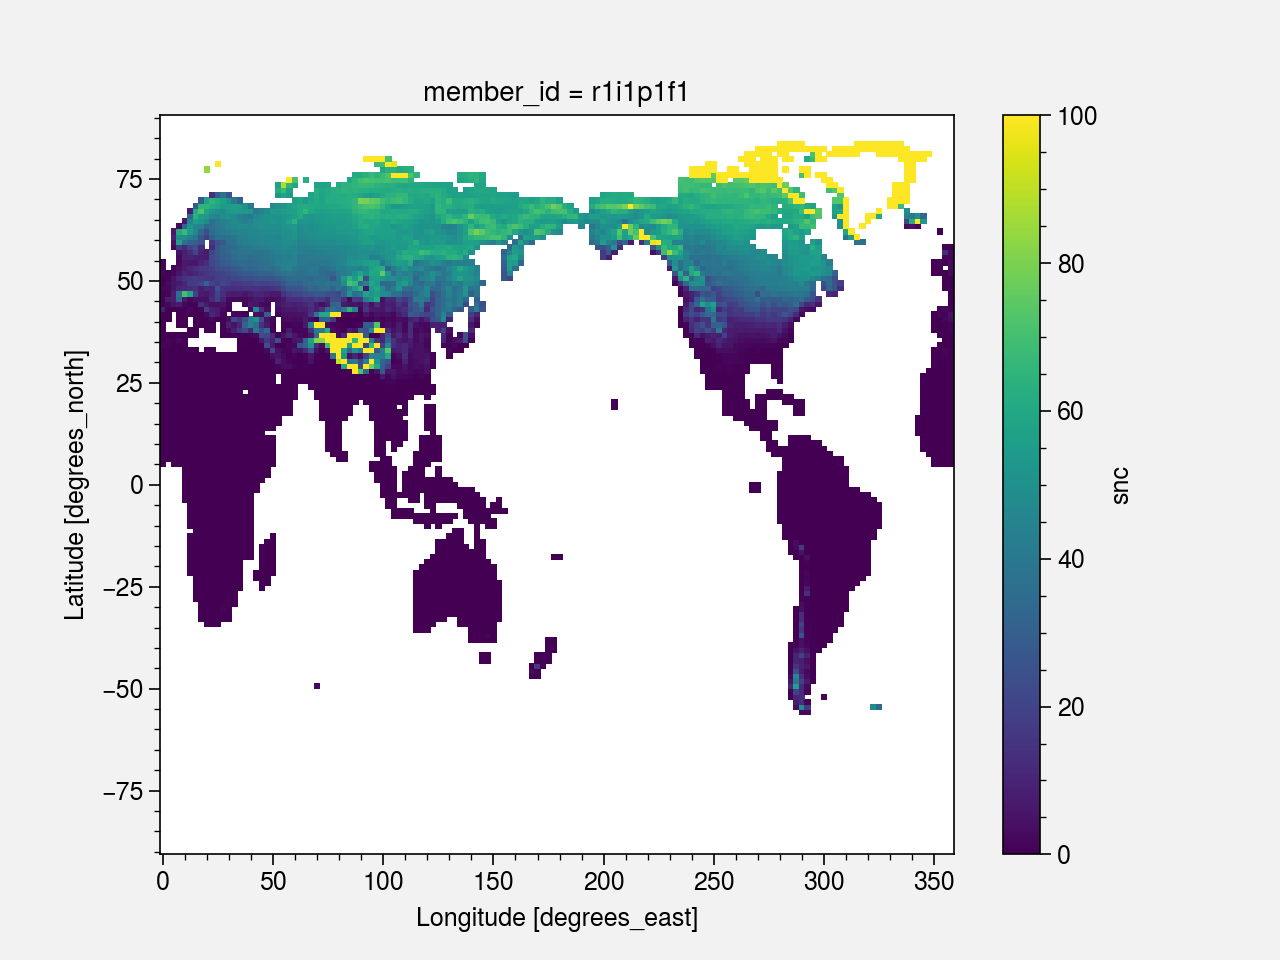

In [67]:
model_clim.plot()

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


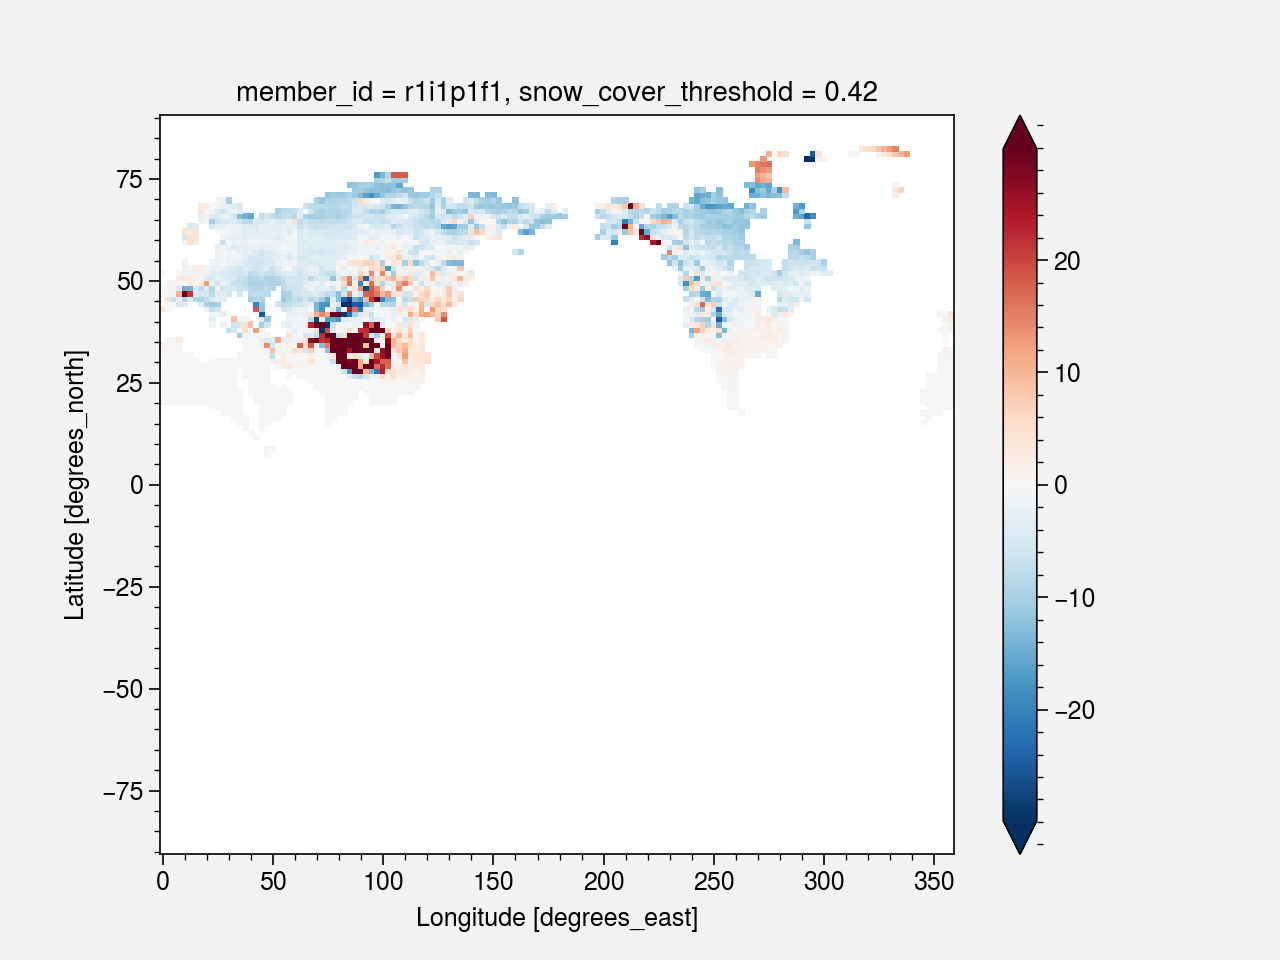

In [70]:
(model_clim - obs_clim).plot(robust=True)

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


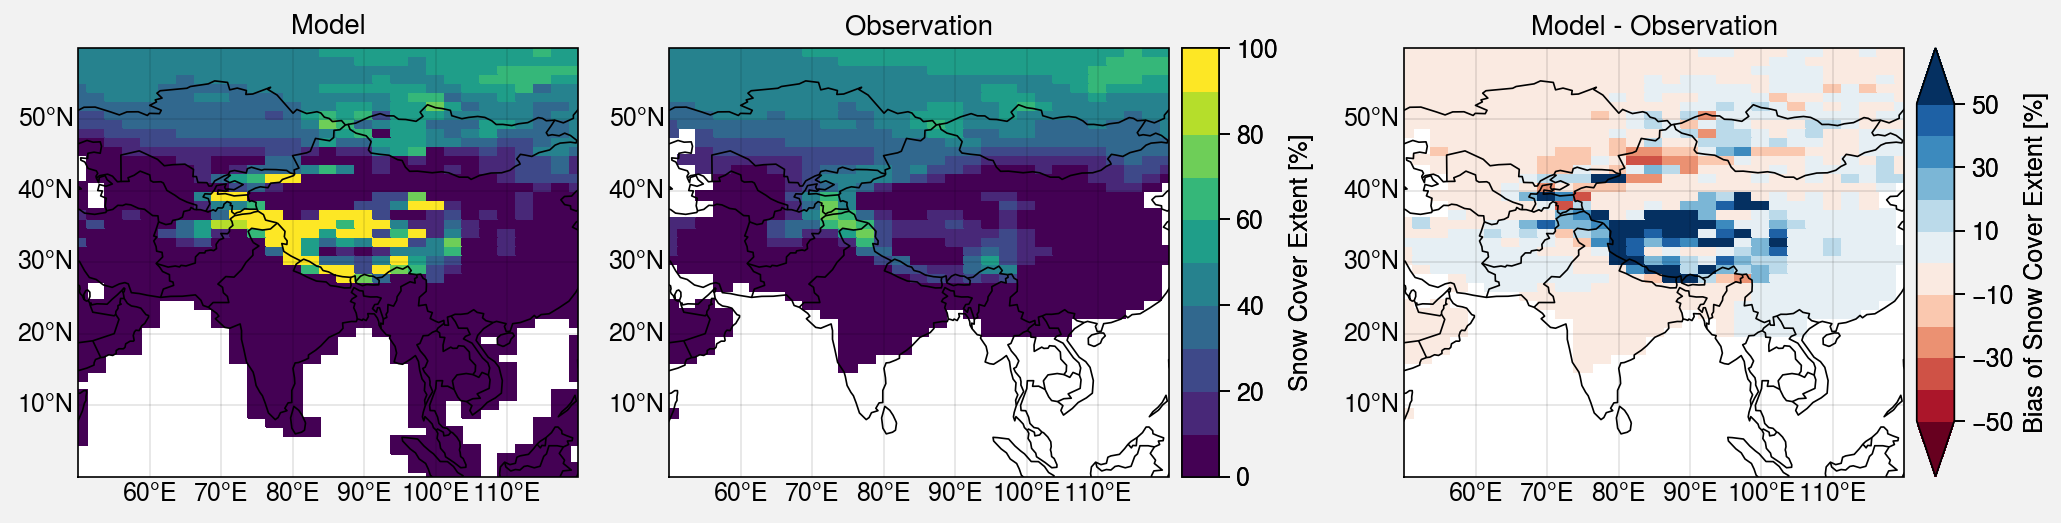

In [84]:
lonlim = slice(50,120)
latlim = slice(0,60)

cmap_snc = 'viridis'
levels_snc = plot.arange(0,100,10)
extend_snc = 'neither'

cmap_bias = 'RdBu'
levels_bias = plot.arange(-50,50,10)
extend_bias = 'both'

fig, axs = plot.subplots(ncols=3, proj='cyl')

m = axs[0].pcolormesh(model_clim.sel(lat=latlim, lon=lonlim), cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
axs[0].format(title='Model')

axs[1].pcolormesh(obs_clim.sel(lat=latlim, lon=lonlim), cmap=cmap_snc, levels=levels_snc, extend=extend_snc)
axs[1].format(title='Observation')
axs[1].colorbar(m, label='Snow Cover Extent [%]')

m = axs[2].pcolormesh((model_clim-obs_clim).sel(lat=latlim, lon=lonlim), cmap=cmap_bias, levels=levels_bias, extend=extend_bias)
axs[2].format(title='Model - Observation')
axs[2].colorbar(m, label='Bias of Snow Cover Extent [%]')

axs.format(
    coast=True, borders=True, labels=True,
    suptitle='',
    lonlim=(lonlim.start,lonlim.stop),
    latlim=(latlim.start,latlim.stop)
)